In [39]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

## Full-field solution

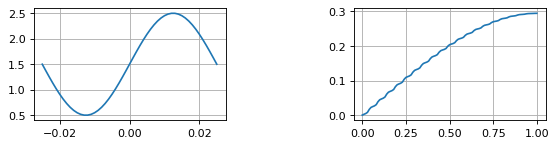

In [40]:
wavelength = 1.0/20;
wavenumber = 2*pi/wavelength
C = Expression("a + sin(k*x[0])", a=1.5, k=wavenumber, degree=2)

# create a very fine mesh so that it the finite element solution can capture
# the fluctuation in the material parameter C
mesh = UnitIntervalMesh(100)
V_ff = FunctionSpace(mesh, "Lagrange", 2)

u = TrialFunction(V_ff)
v = TestFunction(V_ff)
a = dot(grad(v), C * grad(u)) * dx 
L = Expression("x[0]", degree=2) * v * dx
# solve PDE for the full-field solution
u_ff = Function(V_ff)
solve(a == L, u_ff, DirichletBC(V_ff, Constant(0.0), (
    lambda x, on_boundary: near(x[0], 0, 
                                DOLFIN_EPS_LARGE) and on_boundary)))

# plot material parameter and solution
plt.figure(figsize=(8,3.5), dpi=80)
plt.subplot(position=[0.1, 0.1, 0.3, 0.4])
plot(project(C, V)); plt.grid()
plt.subplot(position=[0.6, 0.1, 0.3, 0.4])
plot(u_ff); plt.grid()

## Microscopic BVP and macroscopic elastic tensor

Solve microscopic boundary value problem
\begin{equation}
    \frac{d}{d x}(C(x) (\tilde{u}^{\prime} + \overline{\epsilon}) = 0, \quad x \in \mathcal{R}
\end{equation}
with the periodic boundary condition on $\tilde{u}$. To eliminate the rigid-body motion, we add one artificial condition
\begin{equation}
    \int_{\mathcal{R}} u dx = 0
\end{equation}

This BVP can be cast into the variational formulation as follows
\begin{equation}
    \int_{\mathcal{R}} \nabla v\,{}C(x)\,{} \nabla \tilde{u}\,{}\mathrm{d}x = -\int_{\mathcal{R}} \nabla v\,{} C(x)\,{} \overline{\epsilon} \mathrm{d} x\quad \forall v \in H_{\#}^{1}(\mathcal{R}),
\end{equation}
where $H_{\#}^{1}(\mathcal{R})$ is the Sobolev space of function $v$ which is periodic on $\partial\mathcal{R}$.

### Mesh and periodic constraint

In [ ]:
# Generate mesh
wavelength = 1.0/20
wavenumber = 2*np.pi/wavelength
vertices = np.array([-wavelength/2, wavelength/2])
mesh_RVE = IntervalMesh(50, vertices[0], vertices[1])

# volume of the RVE
vol = vertices[1] - vertices[0]

# Material parameter
kappa = Expression("a + sin(k*x[0])", a=1.5, k=wavenumber, degree=2)

# Define the periodic boundary condition which is used later to define a 
# function space with constrained domain
class PeriodicBoundary(SubDomain):
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.vertices = vertices
        self.TOL = TOL
        
    def inside(self, x, on_boundary):
        return near(x[0], self.vertices[0], 
                    self.TOL) and on_boundary
    
    # Map the point x to y. The solution at y should be equal 
    # to its value at x, where x belongs to the boundary parts 
    # defined by method "inside" (see above)
    def map(self, x, y):
        y[0] = x[0] - (self.vertices[1] - self.vertices[0])
        
# Kinematic and kinetic variables
def epsilon(u):
    return u.dx(0)

def sigma(u, eps_):
    return kappa * (u.dx(0) + eps_)

### Fluctuation field: solution with rigid body motion mode

Even with only periodic condition, we can still obtain the solution. This is possible due to the iterative solver employed in FEniCS function **solve**. In fact, by constraining the fluctuation field with only periodic condition, the solution is only determined up to one constant. To define a well-posed microscopic BVP, we need at least one more Dirichlet condition. This condition can be as fixing the solution at one node by a certain value. Alternatively, we can also impose
\begin{equation}
    \int_{\mathcal{R}} u\,{}\mathrm{d}x = 0,
\end{equation}
where $\mathcal{R}$ is the spatial domain of the representative volume element (RVE).

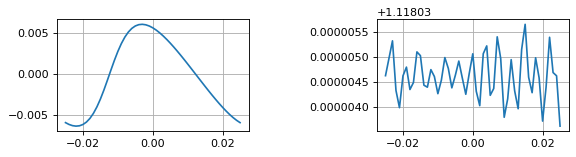

In [44]:
V = FunctionSpace(mesh_RVE, "Lagrange", 2, 
                  constrained_domain=PeriodicBoundary(vertices))
u = TrialFunction(V)
v = TestFunction(V)
MacroGrad = Constant(1.0)
F = dot(epsilon(v), sigma(u, MacroGrad))*dx
a, L = lhs(F), rhs(F)
w = Function(V)
# solve(a == L, w, DirichletBC(V, 0.0, fixLeftNode))
solve(a == L, w, [], solver_parameters={'linear_solver': 'cg',
                         'preconditioner': 'ilu'})

plt.figure(figsize=(8,3.5), dpi=80)
plt.subplot(position=[0.1, 0.1, 0.3, 0.4])
plot(w); plt.grid()
plt.subplot(position=[0.6, 0.1, 0.3, 0.4])
plot(sigma(w, MacroGrad)); plt.grid()

### Fluctuation field: solution by removing rigid-body mode

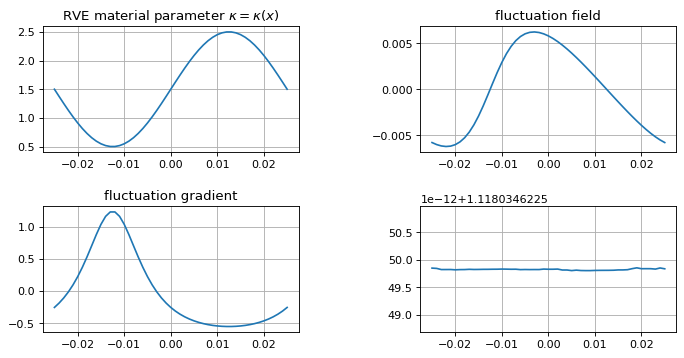

In [62]:
ElemU = FiniteElement("CG", mesh_RVE.ufl_cell(), 2)
# this produces only one scalar (function with only one 1 DOF, its value)
ElemL = FiniteElement("R", mesh_RVE.ufl_cell(), 0) 
W = FunctionSpace(mesh_RVE, MixedElement([ElemU, ElemL]), 
                  constrained_domain=PeriodicBoundary(vertices))

(u, c) = TrialFunctions(W)   # u is the fluctuation, c is the Lagrange multiplier
(v, d) = TestFunctions(W)    # test function dual to u and c

MacroGrad = Constant(1.0)
a = dot(epsilon(v), kappa * epsilon(u))*dx + (c*v + u*d)*dx 
L = -dot(epsilon(v), kappa * MacroGrad)*dx
# F = dot(epsilon(v), sigma(u, MacroGrad))*dx + (c*v + u*d)*dx 
# a, L = lhs(F), rhs(F)
w = Function(W)

solve(a == L, w, [])

u_fluc, lagrange_mul = w.split()

plt.figure(figsize=(8,4.5), dpi=80)
plt.subplot(position=[0.01, 0.9, 0.4, 0.35])
plot(project(kappa, FunctionSpace(mesh_RVE, 'CG', 1)), title="RVE material parameter $\kappa = \kappa(x)$"); plt.grid();

plt.subplot(position=[0.6, 0.9, 0.4, 0.35])
plot(u_fluc, title="fluctuation field"); plt.grid()

plt.subplot(position=[0.01, 0.4, 0.4, 0.35])
plot(u_fluc.dx(0), title="fluctuation gradient"); plt.grid()

plt.subplot(position=[0.6, 0.4, 0.4, 0.35])
plot(sigma(u_fluc, MacroGrad)); plt.grid(); 


### Fluctuation field in terms of gradient variable

Averaging of gradient fluctuation = -1.2468324983583301e-18


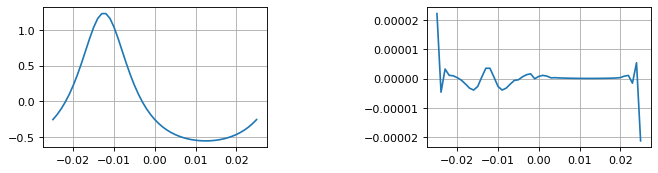

In [89]:
ElemP = FiniteElement("CG", mesh_RVE.ufl_cell(), 2)
ElemL = FiniteElement("R", mesh_RVE.ufl_cell(), 0)
W_PL = FunctionSpace(mesh_RVE, MixedElement([ElemP, ElemL]), 
                  constrained_domain=PeriodicBoundary(vertices))

(p, c) = TrialFunctions(W_PL)
(q, d) = TestFunctions(W_PL)
MacroGrad = Constant(1.0)
F = dot(q, kappa * (p + MacroGrad))*dx + (p*d + c*q)*dx
a, L = lhs(F), rhs(F)
# a = dot(q, kappa * p) *dx + (p*d + c*q) *dx
# L = -dot(q, kappa * MacroGrad)*dx
w = Function(W_PL)
# solve(a == L, w, DirichletBC(V, 0.0, fixLeftNode))
solve(a == L, w, [], solver_parameters={'linear_solver': 'cg',
                         'preconditioner': 'ilu'})
p_fluc, lagrange_mul = w.split()

plt.figure(figsize=(8, 5), dpi=80)
plt.subplot(position=[0, 0, 0.35, 0.35]); plot(p_fluc); plt.grid()
plt.subplot(position=[0.6, 0, 0.35, 0.35]);
plot(project(u_fluc.dx(0), FunctionSpace(mesh_RVE, ElemP)) - p_fluc);
plt.grid()
print("Averaging of gradient fluctuation =", assemble(p_fluc*dx))

## Homogenized solution vs full-field solution

In [91]:
# We integrate stress by using "assemble(stress)" provided by fenics.
C_Macro = assemble(kappa*(p_fluc + MacroGrad)*dx) / wavelength
print(C_Macro)
print("C_Macro_num - C_Macro_anal =", C_Macro - np.sqrt(5)/2)

Calling FFC just-in-time (JIT) compiler, this may take some time.
1.1180342217891865
C_Macro_num - C_Macro_anal = 2.3303929164164572e-07


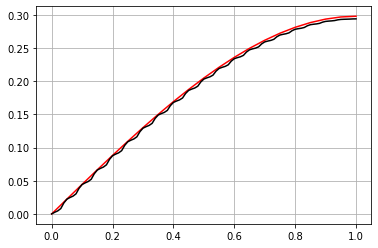

In [92]:
mesh_Macro = UnitIntervalMesh(20)
V_Macro = FunctionSpace(mesh_Macro, "CG", 2)

def boundary(x, on_boundary):
    return near(x[0], 0, 1E-10) and on_boundary

f = Expression("x[0]", degree=2)

u = TrialFunction(V_Macro)
v = TestFunction(V_Macro)
a = dot(grad(v), Constant(C_Macro) * grad(u)) * dx 
L = f * v * dx
# solve PDE
u_homo = Function(V_Macro)
solve(a == L, u_homo, 
      DirichletBC(V_Macro, Constant(0.0), 
                  lambda x, on_boundary: near(x[0], 0) and on_boundary))

plot(u_homo, color='red', linestyle="-"); plt.grid()
plot(u_ff, color="black")